# Unsupervised Machine Learning

# 1. Importing libraries

In [20]:
# Core
import pandas as pd
import numpy as np

# Visualization (use matplotlib for consistency)
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10, 5)

In [25]:
# importing bitcoin price data
df = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', parse_dates=['Timestamp'])
df = df.sort_values('Timestamp').set_index('Timestamp')

/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_86909/3671590988.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv', parse_dates=['Timestamp'])


In [26]:
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
1325412060.0,4.58,4.58,4.58,4.58,0.0
1325412120.0,4.58,4.58,4.58,4.58,0.0
1325412180.0,4.58,4.58,4.58,4.58,0.0
1325412240.0,4.58,4.58,4.58,4.58,0.0
1325412300.0,4.58,4.58,4.58,4.58,0.0


In [27]:
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [28]:
# Convert epoch-seconds strings like "1325412060.0" to datetime
df = df.copy()
df.index = pd.to_datetime(df.index.astype('float64'), unit='s')
df = df.sort_index()

print(df.index.min(), df.index.max())  # should show 2012-...
print(df.head(3))


2012-01-01 10:01:00 2025-09-25 23:57:00
                     Open  High   Low  Close  Volume
Timestamp                                           
2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0


# 2) Feature Engineering (Rolling returns, volatility, and volume)

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Create features ---
window = 60  # 60 minutes rolling window

df['log_close'] = np.log(df['Close'].replace(0, np.nan))
df['return'] = df['log_close'].diff()
df['volatility'] = df['return'].rolling(window=window, min_periods=window//2).std()
df['dlog_vol'] = np.log1p(df['Volume']).diff()

# Select relevant features and clean
features = df[['return', 'volatility', 'dlog_vol']].replace([np.inf, -np.inf], np.nan).dropna()
features = features[(features != 0).any(axis=1)]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# 2. Elbow Technique – Find Optimal k

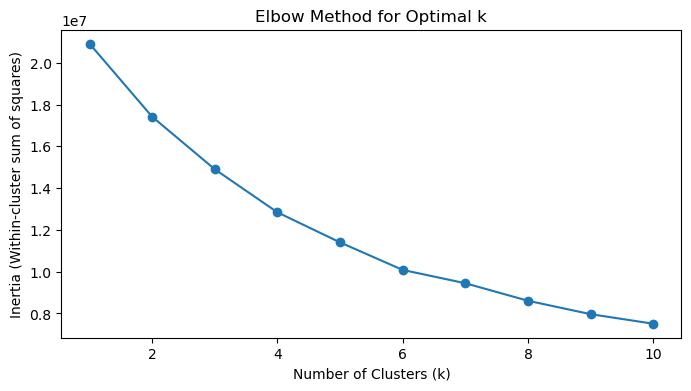

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.show()


# 3. Run K-Means with 3 clusters

In [32]:
k_final = 3 

kmeans = KMeans(n_clusters=k_final, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

# Attach cluster labels back to your main df
df = df.join(features['cluster'])

# 4. Visualize Clusters

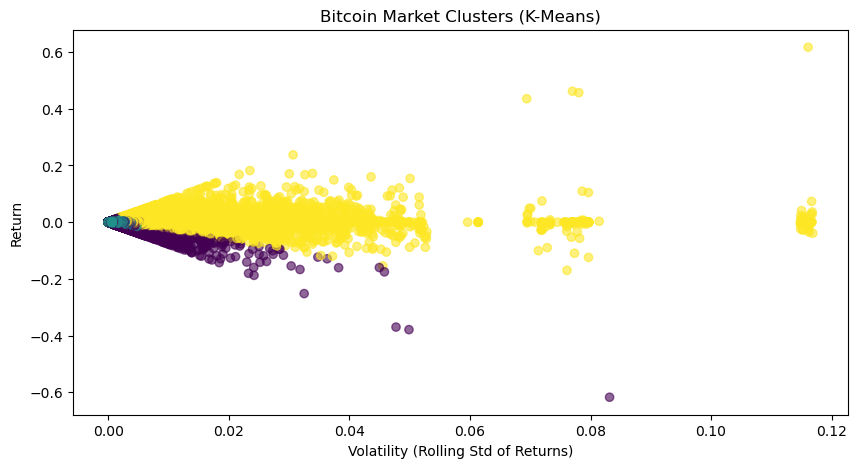

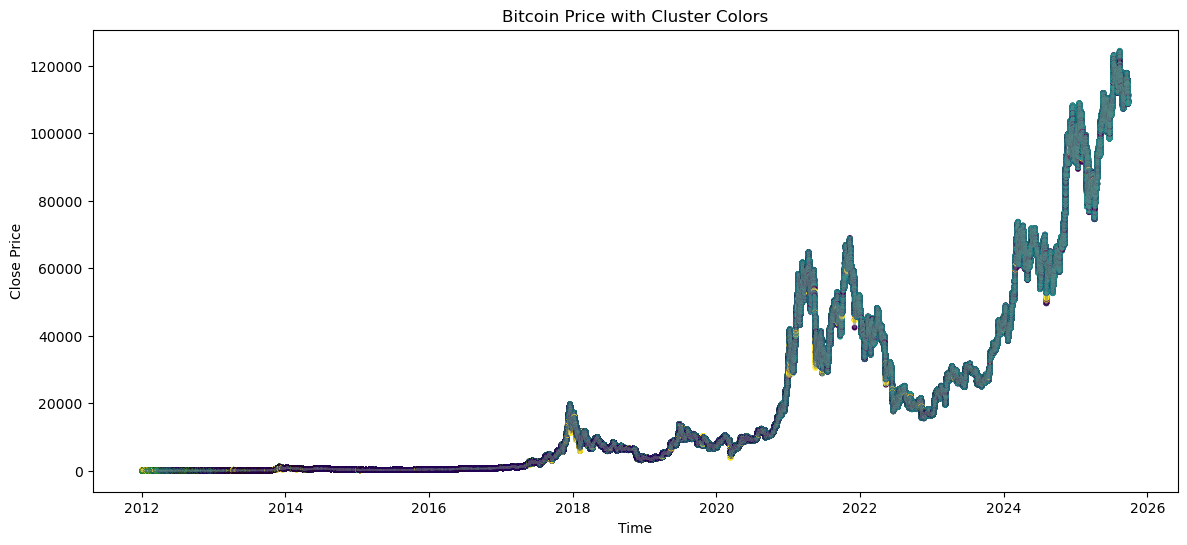

In [33]:
plt.figure(figsize=(10,5))
plt.scatter(features['volatility'], features['return'],
            c=features['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Volatility (Rolling Std of Returns)')
plt.ylabel('Return')
plt.title('Bitcoin Market Clusters (K-Means)')
plt.show()

plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], color='gray', alpha=0.5)
plt.scatter(df.loc[features.index, 'Timestamp'] if 'Timestamp' in df.columns else df.loc[features.index].index,
            df.loc[features.index, 'Close'], 
            c=features['cluster'], cmap='viridis', s=10)
plt.title('Bitcoin Price with Cluster Colors')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()


# 5. Cluster Descriptive Statistics

In [35]:
summary = features.groupby('cluster')[['return', 'volatility', 'dlog_vol']].mean()
print(summary)

           return  volatility  dlog_vol
cluster                                
0       -0.000342    0.001281  1.379602
1        0.000023    0.000966 -0.368143
2        0.001837    0.006072 -0.148012


### Cluster Interpretation
- **Cluster 0** – High volatility and positive returns → likely breakout phases.
- **Cluster 1** – Low volatility and small volume changes → sideways/consolidation.
- **Cluster 2** – Moderate volatility and negative returns → pullbacks or corrections.

These groups help identify distinct Bitcoin market regimes.  

The clustering results show that the Bitcoin market spends most of its time in a calm, low-volatility state.
The majority of observations belong to Cluster 1, which is characterized by very small average returns, low volatility, and slightly declining trading volumes.
This suggests that, despite Bitcoin’s reputation for extreme price movements, long periods of sideways consolidation dominate its history.
In contrast, Clusters 0 and 2 represent exceptional market regimes — phases of strong collective behavior where prices move rapidly in either direction.
Cluster 2 captures bullish breakouts with high volatility and positive returns, while Cluster 0 corresponds to panic sell-offs, where volumes spike and returns turn negative.
Overall, the analysis highlights that explosive rallies or crashes are rare but decisive moments separating long stretches of stability.
This cyclical structure aligns with well-known Bitcoin market dynamics: extended accumulation phases interrupted by sudden expansions or corrections.

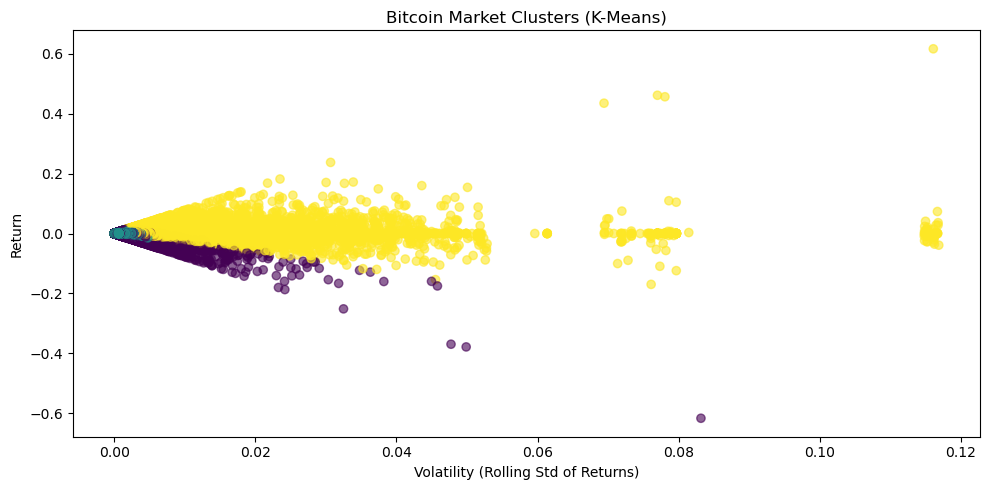

In [36]:
# save images
plt.figure(figsize=(10,5))
plt.scatter(features['volatility'], features['return'],
            c=features['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Volatility (Rolling Std of Returns)')
plt.ylabel('Return')
plt.title('Bitcoin Market Clusters (K-Means)')
plt.tight_layout()
plt.savefig("/Users/davidscheider/anaconda_projects/Bitcoin Analytics/cluster_scatter.png", dpi=300)
plt.show()


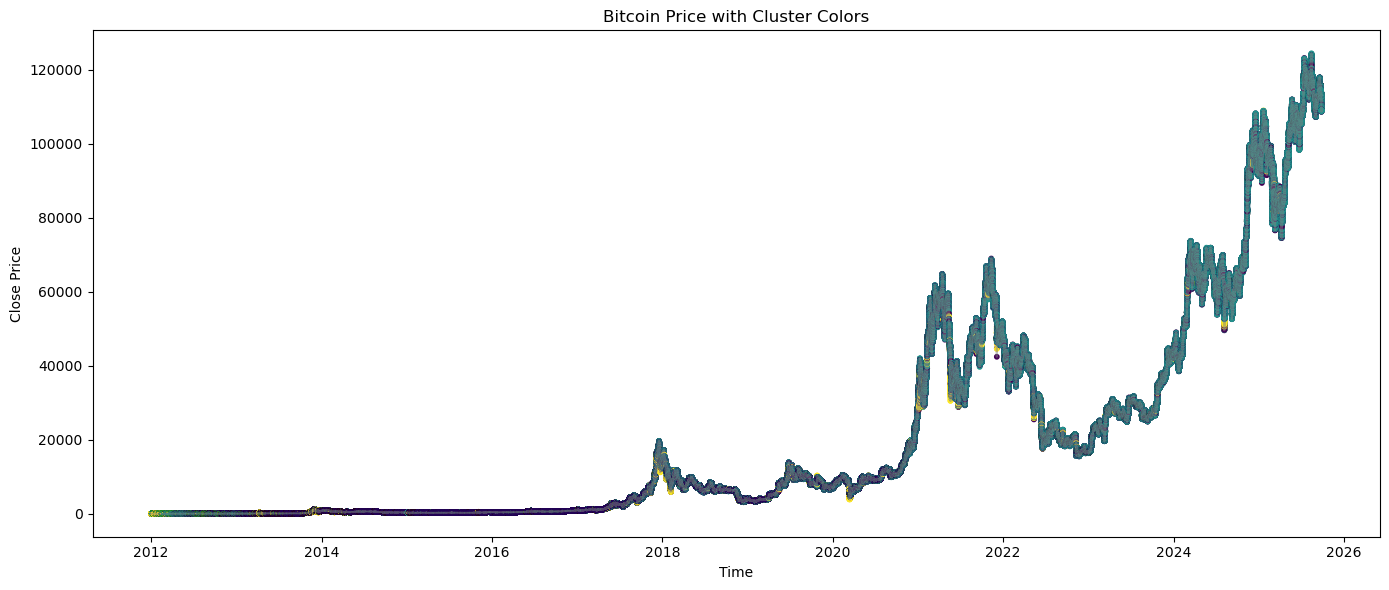

In [37]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], color='gray', alpha=0.5)
plt.scatter(df.loc[features.index].index,
            df.loc[features.index, 'Close'],
            c=features['cluster'], cmap='viridis', s=10)
plt.title('Bitcoin Price with Cluster Colors')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.tight_layout()
plt.savefig("/Users/davidscheider/anaconda_projects/Bitcoin Analytics/price_clusters.png", dpi=300)
plt.show()
